# 3.3 Generate tables for the multi-layer network

We limited the multilayer network from 25 to 100 min (16 layers - 1st cell cycle).

First, the interactome was built such as:

1. All interactions were set as undirected.
2. A confidence score of 1 was assigned to the PDIs.
3. Multi-edges were aggregated from the PPI table, such as the mean of PPI scores for a given node pair was calculated.
4. The final score of an edge between a given node pair was calculated with the function: `(2 * P + D) / 4`, where P is the PPI score and D is the number of PDI edges between the node pair.

Node weights were calculated such as:

1. Mean of logCPM across time for each gene.
2. Node weights were computed with: `|logCPM - avgLogCPM|`. Nodes which were not present in the RNA-sequencing dataset were filtered out.
3. Then, for each column, weights were normalized to a range between 0.001 and 1, as the null weight is not managed by AnatApp.

A node was tagged as a query for a given layer if the absolute value of the log fold change is higher than 0.5 at this layer. 

Inter-layer edge's weights were computed using `( wDys1 + wDys2 ) / ( 1 + wDys1 + wDys2 )`, where wDys1 and wDys2 are the weights of the node in the layer i and i+1, respectively.

## Input

* `data-create_networks/cell_cycle_genes/20AUG2020_KEGG_sce04111_genes.txt` cell-cycle genes from the KEGG pathway `sce04111 Cell cycle - yeast`.
* `data-create_networks/yeastract_TF/protein_DNA_interactions.tsv`: cleaned protein-dna interactions of transcription factors from YEASTRACT database with locus names.
* `data-create_networks/hitpredit-03Aug2020/protein_protein_interactions.tsv`: cleaned HitPredict protein-protein interaction network.
* `data-create_networks/yeast_Kelliher_2016/yeast_WT_logCPM_noRep.txt`: normalized counts in log CPM.

## Output

* `data-create_networks/yeast_multiLayerNetwork/nodeTable_noRep.tsv`: node table of the multi-layer network.
* `data-create_networks/yeast_multiLayerNetwork/intraLayerEdgeTable_noRep.tsv`: intra-layer edge table of the multi-layer network.
* `data-create_networks/yeast_multiLayerNetwork/interLayerEdgeTable_noRep.tsv`: inter-layer edge table of the multi-layer network.

In [63]:
import pandas as pd
import numpy as np
import glob

In [64]:
kegg_genes_file = '../../data-create_networks/cell_cycle_genes/20AUG2020_KEGG_sce04111_genes.txt'
pdiTable_file = '../../data-create_networks/yeastract_TF/protein_DNA_interactions.tsv'
ppiTable_file = '../../data-create_networks/hitpredit-03Aug2020/protein_protein_interactions.tsv'
logCPM_file = '../../data-create_networks/yeast_Kelliher_2016/yeast_WT_logCPM_noRep.txt'

nodeTable_file = '../../data-create_networks/yeast_multiLayerNetwork/nodeTable_noRep.tsv'
intraTable_file = '../../data-create_networks/yeast_multiLayerNetwork/intraLayerEdgeTable_noRep.tsv'
interTable_file = '../../data-create_networks/yeast_multiLayerNetwork/interLayerEdgeTable_noRep.tsv'

lfcCutoff = 0.25

## Import data

In [65]:
ppi = pd.read_csv( ppiTable_file, sep='\t' )
pdi = pd.read_csv( pdiTable_file, sep='\t' )
logCPM = pd.read_csv( logCPM_file, sep='\t', index_col=0 )
kegg_genes = pd.read_csv( kegg_genes_file, sep='\t', header=None )

## Build the interactome

Merge PPI and PDI edges and compute their scores.

In [66]:
# sort sources and targets to compare both dataframes
undiPPI = ppi.copy()
undiPPI[['source','target']] = np.sort( undiPPI[['source','target']].values )
undiPDI = pdi.copy()
undiPDI[['source','target']] = np.sort( undiPDI[['source','target']].values )

# give a score to the PDI equal to the number of PDIs
undiPDI['score'] = 1.
undiPDI = undiPDI.groupby(by=['source', 'target']).count().reset_index()

# aggregate multi edges of PDI table and multiple by 2 (because 1 undirected edge = 2 directed edge)
undiPPI = undiPPI.groupby(['source', 'target']).mean().reset_index()
undiPPI['score'] = undiPPI['score'] * 2

# merge dataframes
interactome = pd.merge( undiPPI, undiPDI, on=['source', 'target'], how='outer',
                        indicator=True, suffixes=['_ppi', '_pdi']
                      ).rename({'_merge': 'edge type'}, axis=1
                      ).replace({'left_only': 'PPI', 'right_only': 'PDI', 'both': 'PPI+PDI'})

# compute final scores
interactome['score'] = interactome[['score_ppi', 'score_pdi']].fillna(0).sum(axis=1) / 4
interactome = interactome[['source', 'target', 'score', 'edge type']
                         ].rename({'score': 'Weight'}, axis=1)

x = interactome.groupby('edge type').count()[['source']].rename({'source': 'interactions'}, axis=1).T
x['Total'] = x.sum(axis=1)
x

edge type,PDI,PPI,PPI+PDI,Total
interactions,11291,99042,151,110484


In [108]:
interactome.to_csv('interactome.csv')

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

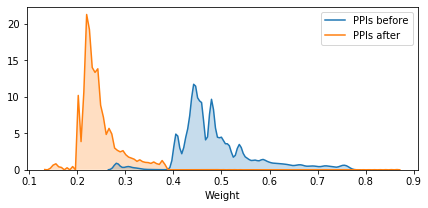

In [69]:
df = pd.merge( undiPPI, undiPDI, on=['source', 'target'], how='outer',
                        indicator=True, suffixes=['_ppi', '_pdi']
                      ).rename({'_merge': 'edge type'}, axis=1
                      ).replace({'left_only': 'PPI', 'right_only': 'PDI', 'both': 'PPI+PDI'})

df[df['edge type'].isin(['PPI+PDI'])]['score_ppi']


fig, ax = plt.subplots(figsize=(7,3))

data = df[df['edge type'].isin(['PPI','PPI+PDI'])]['score_ppi'] / 2
sns.distplot(data, hist=False, ax=ax, kde_kws={'shade':True}, label='PPIs before')

data = interactome[df['edge type'].isin(['PPI','PPI+PDI'])]['Weight']
sns.distplot(data, hist=False, ax=ax, kde_kws={'shade':True}, label='PPIs after')

plt.savefig('confidence weight distribution.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

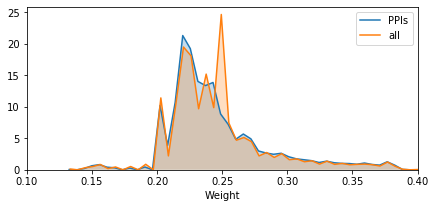

In [70]:
fig, ax = plt.subplots(figsize=(7,3))

data = interactome[df['edge type'].isin(['PPI','PPI+PDI'])]['Weight']
sns.distplot(data, hist=False, ax=ax, kde_kws={'shade':True}, label='PPIs')

data = interactome['Weight']
sns.distplot(data, hist=False, ax=ax, kde_kws={'shade':True}, label='all')

plt.xlim([0.1,0.4])

plt.savefig('confidence weight distribution all vs PPIs.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

## Build the node table

Compute node weights for each layer from the difference the normalized counts and their average.

In [71]:
nodes = set(interactome['source']) | set(interactome['target'])
print('interactome nodes:', len(nodes))

# compute node weight
nodeWeight = abs( logCPM.T - logCPM.mean(axis=1) ).T

# keep the genes with RNA-seq values and which are within the interactome
genesToKeep = set(nodeWeight.index) & nodes
nodeWeight = nodeWeight.loc[ genesToKeep , : ]
intraLayerEdgeTable = interactome[ interactome['source'].isin(genesToKeep)
                                   & interactome['target'].isin(genesToKeep)
                                 ].reset_index(drop=True)

# normalize between 0.001 and 1, according to anatapp needs
nodeWeight = ( 1 - 0.001 ) * ( nodeWeight / nodeWeight.max() ).fillna(0) + 0.001
nodeWeight.columns = [ 'Weight_' + str(i) for i in range(1, len(nodeWeight.columns) + 1) ]

# print
print('genes with RNA-seq values and within the interactome:', len(genesToKeep))
print('edges filtered out:', len(interactome) - len(intraLayerEdgeTable))
    
x = intraLayerEdgeTable.groupby('edge type').count()[['source']
                      ].rename({'source': 'interactions'}, axis=1).T
x['Total'] = x.sum(axis=1)
x

interactome nodes: 5979
genes with RNA-seq values and within the interactome: 5785
edges filtered out: 1047


edge type,PDI,PPI,PPI+PDI,Total
interactions,10938,98348,151,109437


In [72]:
print('meaning of layer IDs:')
for i, c in enumerate( nodeWeight.columns.get_level_values(0).unique() ): print(i+1, '\t', c)

meaning of layer IDs:
1 	 Weight_1
2 	 Weight_2
3 	 Weight_3
4 	 Weight_4
5 	 Weight_5
6 	 Weight_6
7 	 Weight_7
8 	 Weight_8
9 	 Weight_9
10 	 Weight_10
11 	 Weight_11
12 	 Weight_12
13 	 Weight_13
14 	 Weight_14
15 	 Weight_15
16 	 Weight_16


In [109]:
queries

,Query_1,Query_2,Query_3,Query_4,Query_5,Query_6,Query_7,Query_8,Query_9,Query_10,Query_11,Query_12,Query_13,Query_14,Query_15,Query_16
YER045C,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
YKL033W-A,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
YMR218C,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
YMR140W,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
YGR071C,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YGR048W,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
YJL033W,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
YOL087C,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
YJL181W,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False


In [73]:
# get queries per layer
queries = ( nodeWeight >= lfcCutoff )
queries.columns = [ 'Query_' + str(i) for i in range(1, len(queries.columns) + 1) ]

pd.DataFrame(
    [ [ queries[c].sum(),
        queries[queries[c]].index.isin(kegg_genes[0]).sum() ]
      for c in queries.columns ],
    index = [f'layer {str(i+1)}' for i in range(len(queries.columns))],
    columns = [ '# query nodes', '# KEGG genes in query' ]
)

,# query nodes,# KEGG genes in query
layer 1,243,26
layer 2,148,18
layer 3,242,20
layer 4,193,14
layer 5,132,11
layer 6,135,13
layer 7,172,23
layer 8,249,29
layer 9,264,32
layer 10,281,34


In [74]:
# build table
nodeTable = nodeWeight.reset_index().rename_axis('', axis=1)

# add tag for KEGG genes
kg = kegg_genes[[0]].copy()
kg['Core'] = True
nodeTable = pd.merge( kg, nodeTable, left_on=0, right_on='index', how='right'
                    ).drop( 'index', axis=1 ).rename( {0: 'Node'}, axis=1 )

# add query columns
nodeTable = pd.merge( nodeTable, queries, left_on='Node', right_index=True, how='left'
                    ).fillna(False)

print('core genes within the node table:', len(nodeTable[nodeTable['Core']]))

core genes within the node table: 130


## Build the inter-layer edge table

In [75]:
interLayerEdgeTable = []

# compute the inter-layer edge weights
cols = nodeWeight.columns
for i in range(1, len(cols)):
    wDys1 = nodeWeight[ cols[i-1] ]
    wDys2 = nodeWeight[ cols[i] ]
    interLayerEdgeTable.append( ( wDys1 + wDys2 ) / ( 1 + wDys1 + wDys2 ) )
    
# build the table
interLayerEdgeTable = pd.concat( interLayerEdgeTable, axis=1 )
colNames = [ f'Weight_{i}>{i+1}' for i in range(1, len(cols)) ]
interLayerEdgeTable.columns = colNames
interLayerEdgeTable = interLayerEdgeTable.reset_index().rename({'index': 'source'}, axis=1)
interLayerEdgeTable['target'] = interLayerEdgeTable['source']
interLayerEdgeTable = interLayerEdgeTable[['source', 'target'] + colNames]

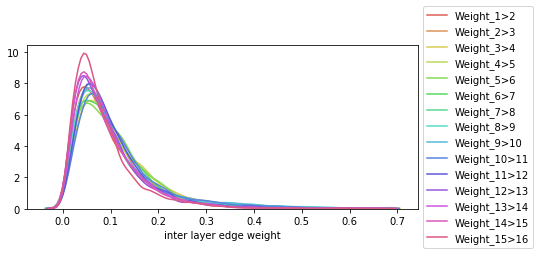

In [107]:
data = interLayerEdgeTable.drop(['source', 'target'], axis=1)

fig, ax = plt.subplots(figsize=(7,3))
colors = sns.color_palette("hls", 15).as_hex()

i=0
for c in data.columns:
    sns.distplot(data[c], hist=False, label=c, ax=ax, color=colors[i])
    i+=1

plt.xlabel('inter layer edge weight')
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('inter layer edge weights.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## Export

In [10]:
# export
nodeTable.to_csv( nodeTable_file, sep='\t', index=False )
intraLayerEdgeTable.to_csv( intraTable_file, sep='\t', index=False )
interLayerEdgeTable.to_csv( interTable_file, sep='\t', index=False )